Importation of all the libraries required for this notebook.

In [ ]:
!pip install plot-keras-history

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9455 sha256=929485741f29e09f87177acb9c4603c781baedd92b01c4e8547b8e01823dacfb
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.51-py3-none-any.whl size=321865 sha256=982f3de9eb9cfbe182d5ee3acd6999bbc7d0fd82fdb1f39914901319a1880322
  Stored in directory: /root/.cache/pip/wheels/30/9f/f5/37d037c39ac8b305590d5956f7021c6ca94b63c68be24f6841
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=d79defcaa231f0b18a5ff3a504b47b069f612c942c185b0994694687d81113cd
  Stored in directo

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import glob
import json
import random
import cv2
import time

from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from plot_keras_history import show_history, plot_history
from keras.models import Sequential
from keras.applications import VGG16

In [ ]:
# Version of the libraries used
print('\n'.join(f'{m.__name__} - {m.__version__}'
                for m in globals().values()
                if getattr(m, '__version__', None)))

For Google Colaboratory (deactivate by commenting if you are on your local machine).

In [ ]:
# For Google Colaboratory
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
%cd '/content/gdrive/MyDrive/Master Ingénieur IA [OC]/Slides Projets/Projet #8/'

/content/gdrive/MyDrive/Master Ingénieur IA [OC]/Slides Projets/Projet #8


---

In [ ]:
# Create a matching dictionary
mapping = {
    'road': 'flat',
    'sidewalk': 'flat',
    'parking': 'flat',
    'rail track': 'flat',
    'person': 'human',
    'rider': 'human',
    'car': 'vehicle',
    'cargroup': 'vehicle',
    'truck': 'vehicle',
    'bus': 'vehicle',
    'on rails': 'vehicle',
    'motorcycle': 'vehicle',
    'bicycle': 'vehicle',
    'caravan': 'vehicle',
    'trailer': 'vehicle',
    'license plate': 'vehicle',
    'ego vehicle': 'vehicle',
    'building': 'construction',
    'wall': 'construction',
    'fence': 'construction',
    'guard rail': 'construction',
    'bridge': 'construction',
    'tunnel': 'construction',
    'pole': 'object',
    'polegroup': 'object',
    'traffic sign': 'object',
    'traffic light': 'object',
    'rectification border': 'object',
    'vegetation': 'nature',
    'terrain': 'nature',
    'sky': 'sky',
    'ground': 'void',
    'dynamic': 'void',
    'static': 'void'
}

In [ ]:
# Set conversion dictionary
# Attention OpenCV reads in BGR and not in RGB!!
label_to_num = {
    'flat': [214, 112, 218],  # Magenta for 'flat'
    'human': [0, 0, 255],  # Red for 'human'
    'vehicle': [255, 0, 0],  # Blue for 'vehicle'
    'construction': [105, 105, 105],  # Gray for 'construction'
    'object': [0, 215, 255],  # Yellow for 'object'
    'nature': [50, 205, 50],  # Green for 'nature'
    'sky': [235, 206, 135],  # Light blue for 'sky'
    'void': [0, 0, 0]  # Black for 'void'
}

Here we will group all the subcategories into 8 main categories with the mapping and we are going to assign colors for each main category, here you have to be careful because openCV works in BGR for color assignment and not in RGB !!

---

## **Creation masks 8 categories**  

Here we will recreate the masks to display only the main categories that we recover by grouping the subcategories into their main categories.

To build 'data/train_default' and 'data/val_default' you must create a folder 'data' and create folder 'train_default', 'val_default', in this folder you have to put the subfolders (name of cities) that you have on your downloaded data, you will have the masks, JSON and original image for each image.

Obviously you put on the 'train_default' the sub-folders of the train folder that you downloaded and the same for the 'val_default'.

==> Here the link to download the data : **https://www.cityscapes-dataset.com/dataset-overview/**

In [ ]:
# Main files
main_dirs = ['data/train_default', 'data/val_default']

# Browse main folders
for main_dir in main_dirs:
    # Browse subfolders (cities)
    for city_dir in os.listdir(main_dir):
        # Build subfolder path
        city_path = os.path.join(main_dir, city_dir)

        # Check if it's indeed a folder
        if os.path.isdir(city_path):
            # Browse all JSON files in subfolder
            for json_file in glob.glob(os.path.join(city_path, '*_gtFine_polygons.json')):
                # Load JSON file
                with open(json_file, 'r') as f:
                    data = json.load(f)

                # Create an empty mask
                mask = np.zeros((data['imgHeight'], data['imgWidth'], 3), dtype=np.uint8)

                # Cycle through all objects in the data
                for obj in data['objects']:
                    # Get polygon coordinates
                    polygon = np.array(obj['polygon'], dtype=np.int32)

                    # Get object label
                    label = obj['label']

                    # Check if the label is in the mapping
                    if label in mapping:
                        # Get main category
                        main_category = mapping[label]

                        # Convert main category to a single color
                        label_color = label_to_num[main_category]

                        # Draw the polygon on the mask
                        cv2.fillPoly(mask, [polygon], label_color)

                        # Set save folder
                        save_dir = 'data/masks'

                        # Create the folder if it doesn't exist
                        if not os.path.exists(save_dir):
                            os.makedirs(save_dir)

                        # Set mask file name
                        mask_file = os.path.join(save_dir, os.path.splitext(os.path.basename(json_file))[0] + '_mask.png')

                        # Save mask
                        cv2.imwrite(mask_file, mask)

---

## **Image Data Generator**

Now we will create a class which will automatically process the images and transform them into tables because an image cannot be read in PNG by our model it must be decomposed and transformed into numbers.

Moreover, we will set the possibility of using data augmentation as a parameter.

In [ ]:
class ImageDataGenerator(Sequence):
    def __init__(self, image_files, mask_files, resize, batch_size, augment=False):
        self.image_files = image_files
        self.mask_files = mask_files
        self.resize = resize
        self.batch_size = batch_size
        self.augment = augment
        if self.augment:
            self.aug = iaa.Sequential([
                iaa.Fliplr(0.4),
                iaa.Affine(scale=(0.8, 1.2)),
                iaa.AdditiveGaussianNoise(scale=0.05*255)
            ])

    def __len__(self):
        return int(np.ceil(len(self.image_files) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_files[idx * self.batch_size:(idx + 1) * self.batch_size]

        imgs = []
        masks = []
        for img_file, mask_file in zip(batch_x, batch_y):
            img = cv2.imread(img_file)
            img = cv2.resize(img, (self.resize, self.resize))
            img = img / 255.0
            img = img.astype('float32')

            mask = cv2.imread(mask_file)
            mask = cv2.resize(mask, (self.resize, self.resize))
            mask = self.color_to_class(mask)

            if self.augment:
                img, mask = self.aug.augment_images([img, mask])

            imgs.append(img)
            masks.append(mask)

        return np.array(imgs), np.array(masks)

    def color_to_class(self, mask):
        color_dict = {
            'flat': [214, 112, 218],
            'human': [0, 0, 255],
            'vehicle': [255, 0, 0],
            'construction': [105, 105, 105],
            'object': [0, 215, 255],
            'nature': [50, 205, 50],
            'sky': [235, 206, 135],
            'void': [0, 0, 0]
        }
        class_dict = {k: v for v, k in enumerate(color_dict.keys())}
        mask_class = np.zeros(mask.shape[:2], dtype=np.uint8)
        for class_name, color in color_dict.items():
            mask_class[np.where((mask == color).all(axis=-1))] = class_dict[class_name]
        mask_class = mask_class.astype('int')
        return to_categorical(mask_class, num_classes=len(class_dict))

In [ ]:
# Using the ImageDataGenerator class
image_dir = 'data/images'
mask_dir = 'data/masks'
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]
mask_files = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir)]

# Ensure the same order for image and mask files
image_files.sort()
mask_files.sort()

# Pairing image and mask files
paired_files = list(zip(image_files, mask_files))

# Shuffling the data
random.shuffle(paired_files)

# Selecting a subset of data
paired_files = paired_files[:900]

# Separation into training, validation and test sets
train_files = paired_files[:500]
val_files = paired_files[500:700]
test_files = paired_files[700:900]

# Unzipping the pairs
train_image_files, train_mask_files = zip(*train_files)
val_image_files, val_mask_files = zip(*val_files)
test_image_files, test_mask_files = zip(*test_files)

# Creation of generators
train_generator_aug = ImageDataGenerator(train_image_files, train_mask_files, 256, 4, augment=True)
train_generator = ImageDataGenerator(train_image_files, train_mask_files, 256, 4)
val_generator = ImageDataGenerator(val_image_files, val_mask_files, 256, 4)
test_generator = ImageDataGenerator(test_image_files, test_mask_files, 256, 4)

Here we will create our image generators using the class that we created above and we're going to separate them into a training, validation and testing set, we will have 2 differents training set, 1 training set classic and one with augmented images (we use the data augmentation technic on him).

---

## **Creation Function Dice Coef**  

We will create and use dice coef as a metric to evaluate whether the prediction masks are sufficiently similar to the real masks and therefore see if our models succeed in segmenting the images.

Here, the closer the Dice coefficient is to 1, the closer the similarity between the prediction and the real value is and the further it is and the worse the predictions are and therefore far from the true values.

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean((2. * intersection + smooth)/(union + smooth), axis=0)

---

# **Models**  

We will try the unet_mini model on classic data and on augmented data, the same for the segnet model.

Afterwards we will try transfer learning using the unet with the VGG16 as a pre-trained encoder and then the SegNet with the pre-trained VGG16 encoder, for both case we will try on classic and augmented training data.

In [ ]:
def unet_mini(input_shape=(256, 256, 3), num_classes=8):
    inputs = Input(input_shape)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    up4 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=-1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=-1)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)

    output = Conv2D(num_classes, (1, 1), activation='softmax')(conv5)

    model = Model(inputs=[inputs], outputs=[output])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[dice_coef])

    return model

In [ ]:
# Create the model
model_unet_mini = unet_mini()

In [ ]:
start_time = time.time()

# Train the model
history_unet_mini = model_unet_mini.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    use_multiprocessing=True,
    workers=6,
)

end_time = time.time()
training_time_unet_mini = end_time - start_time
print(f"Training time: {training_time_unet_mini} seconds")

Epoch 1/5
125/125 [==============================] - 1763s 14s/step - loss: 1.3980 - dice_coef: 0.3564 - val_loss: 1.2594 - val_dice_coef: 0.3825
Epoch 2/5
125/125 [==============================] - 577s 5s/step - loss: 1.0449 - dice_coef: 0.5072 - val_loss: 1.0045 - val_dice_coef: 0.5138
Epoch 3/5
125/125 [==============================] - 565s 5s/step - loss: 0.9703 - dice_coef: 0.5462 - val_loss: 0.9227 - val_dice_coef: 0.5772
Epoch 4/5
125/125 [==============================] - 579s 5s/step - loss: 0.9140 - dice_coef: 0.5724 - val_loss: 0.8561 - val_dice_coef: 0.6099
Epoch 5/5
125/125 [==============================] - 583s 5s/step - loss: 0.8991 - dice_coef: 0.5795 - val_loss: 0.8533 - val_dice_coef: 0.5959
Training time: 4119.323437690735 seconds


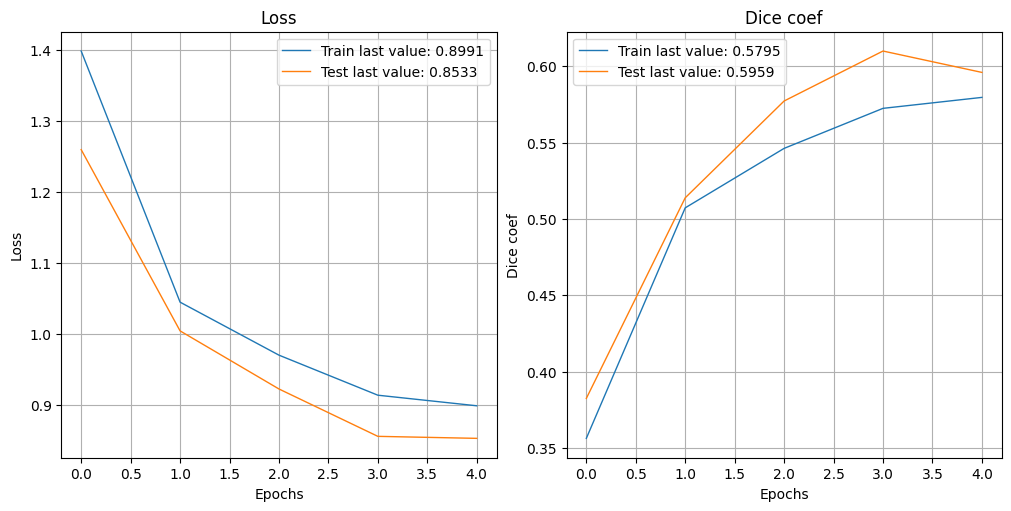

In [ ]:
show_history(history_unet_mini)
plot_history(history_unet_mini, path="history_unet_mini.png")
plt.close()

In [ ]:
# Model evaluation
loss_unet_mini, dice_coef_unet_mini = model_unet_mini.evaluate(test_generator, steps=30)
print('Loss of Unet_mini: {:.2f}'.format(loss_unet_mini))
print('Dice Coefficient of Unet_mini: {:.2f}'.format(dice_coef_unet_mini))

30/30 [==============================] - 109s 4s/step - loss: 0.8327 - dice_coef: 0.5987
Loss of Unet_mini: 0.83
Dice Coefficient of Unet_mini: 0.60


### **Model with Data Augmentation**

In [ ]:
# Create the model
model_unet_mini_aug = unet_mini()

In [ ]:
start_time = time.time()

# Train the model
history_unet_mini_aug = model_unet_mini_aug.fit(
    train_generator_aug,
    steps_per_epoch=len(train_generator_aug),
    epochs=5,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    use_multiprocessing=True,
    workers=6,
)

end_time = time.time()
training_time_unet_mini_aug = end_time - start_time
print(f"Training time: {training_time_unet_mini_aug} seconds")

Epoch 1/5
125/125 [==============================] - 578s 5s/step - loss: 9.1014 - dice_coef: 0.2320 - val_loss: 1.9652 - val_dice_coef: 0.1752
Epoch 2/5
125/125 [==============================] - 594s 5s/step - loss: 2187.1782 - dice_coef: 0.2317 - val_loss: 46.4882 - val_dice_coef: 0.3945
Epoch 3/5
125/125 [==============================] - 592s 5s/step - loss: 12479.1172 - dice_coef: 0.2359 - val_loss: 233.7295 - val_dice_coef: 0.2268
Epoch 4/5
125/125 [==============================] - 592s 5s/step - loss: 345783.7500 - dice_coef: 0.2419 - val_loss: 6781.8037 - val_dice_coef: 0.3965
Epoch 5/5
125/125 [==============================] - 592s 5s/step - loss: 1841134.5000 - dice_coef: 0.2413 - val_loss: 11507.2998 - val_dice_coef: 0.0242
Training time: 3008.65465092659 seconds


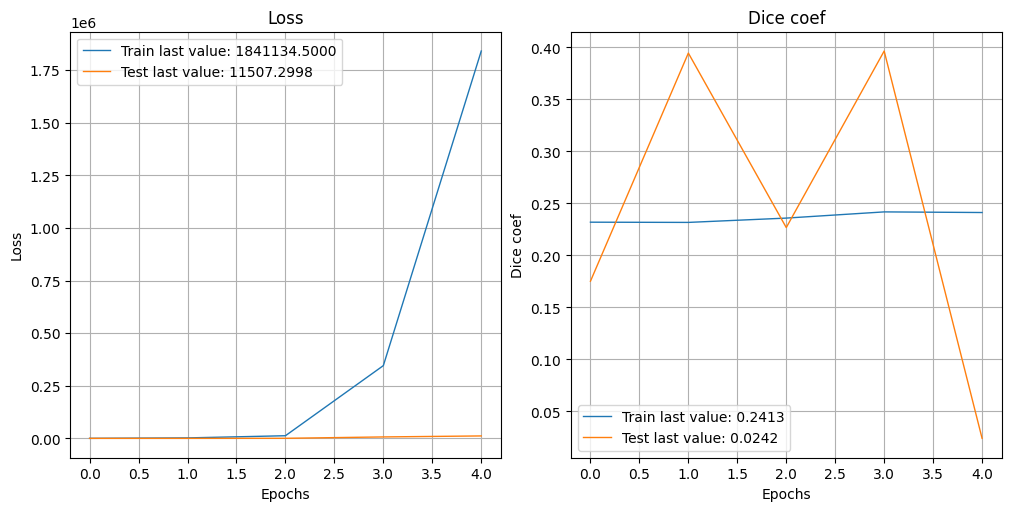

In [ ]:
show_history(history_unet_mini_aug)
plot_history(history_unet_mini_aug, path="history_unet_mini_aug.png")
plt.close()

In [ ]:
# Model evaluation
loss_unet_mini_aug, dice_coef_unet_mini_aug = model_unet_mini_aug.evaluate(test_generator, steps=30)
print('Loss of Unet_mini: {:.2f}'.format(loss_unet_mini_aug))
print('Dice Coefficient of Unet_mini augmented: {:.2f}'.format(dice_coef_unet_mini_aug))

30/30 [==============================] - 42s 1s/step - loss: 10911.3555 - dice_coef: 0.0241
Loss of Unet_mini: 10911.36
Dice Coefficient of Unet_mini augmented: 0.02


---

In [ ]:
def segnet(input_shape=(256, 256, 3), num_classes=8):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Decoder
    up4 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=-1)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up4)
    conv4 = BatchNormalization()(conv4)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)

    output = Conv2D(num_classes, (1, 1), activation='softmax')(conv5)

    model = Model(inputs=[inputs], outputs=[output])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[dice_coef])

    return model

In [ ]:
# Create the model
model_segnet = segnet(input_shape=(256, 256, 3), num_classes=8)

In [ ]:
start_time = time.time()

# Train the model
history_segnet = model_segnet.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    use_multiprocessing=True,
    workers=6,
)

end_time = time.time()
training_time_segnet = end_time - start_time
print(f"Training time: {training_time_segnet} seconds")

Epoch 1/5
125/125 [==============================] - 718s 6s/step - loss: 1.0522 - dice_coef: 0.5468 - val_loss: 2.0439 - val_dice_coef: 0.3191
Epoch 2/5
125/125 [==============================] - 96s 769ms/step - loss: 0.8144 - dice_coef: 0.6297 - val_loss: 3.8054 - val_dice_coef: 0.3982
Epoch 3/5
125/125 [==============================] - 96s 769ms/step - loss: 0.7405 - dice_coef: 0.6594 - val_loss: 2.1424 - val_dice_coef: 0.4688
Epoch 4/5
125/125 [==============================] - 97s 776ms/step - loss: 0.6904 - dice_coef: 0.6819 - val_loss: 2.1656 - val_dice_coef: 0.4586
Epoch 5/5
125/125 [==============================] - 96s 767ms/step - loss: 0.6474 - dice_coef: 0.6989 - val_loss: 1.7021 - val_dice_coef: 0.5089
Training time: 1200.291141986847 seconds


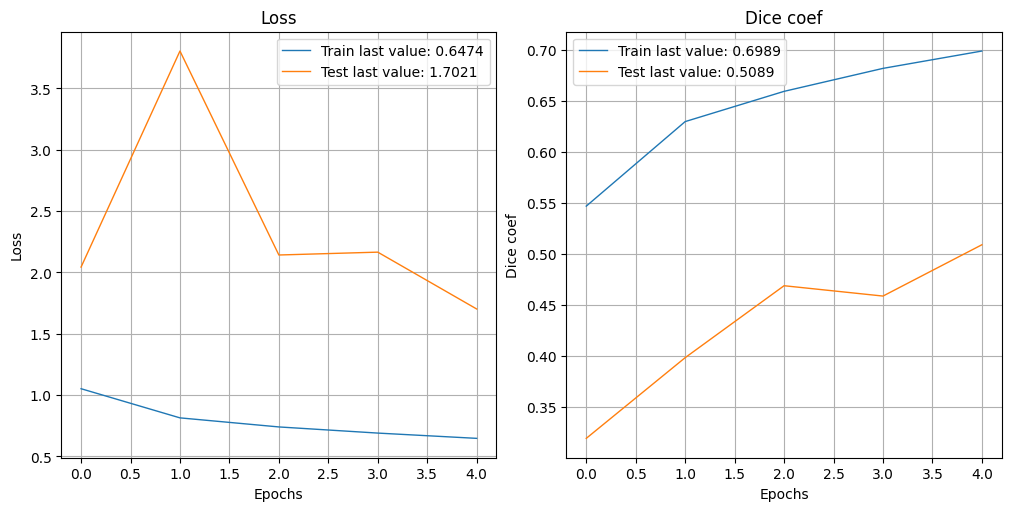

In [ ]:
show_history(history_segnet)
plot_history(history_segnet, path="history_segnet.png")
plt.close()

In [ ]:
# Evaluate the model
loss_segnet, dice_coef_segnet = model_segnet.evaluate(test_generator, steps=30)
print('Loss: {:.2f}'.format(loss_segnet))
print('Dice Coefficient of Segnet: {:.2f}'.format(dice_coef_segnet))

30/30 [==============================] - 74s 3s/step - loss: 1.7494 - dice_coef: 0.5078
Loss: 1.75
Dice Coefficient of Segnet: 0.51


### **Model with Data Augmentation**

In [ ]:
# Create the model
model_segnet_aug = segnet(input_shape=(256, 256, 3), num_classes=8)

In [ ]:
start_time = time.time()

# Train the model
history_segnet_aug = model_segnet_aug.fit(
    train_generator_aug,
    steps_per_epoch=len(train_generator_aug),
    epochs=5,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    use_multiprocessing=True,
    workers=6,
)

end_time = time.time()
training_time_segnet_aug = end_time - start_time
print(f"Training time: {training_time_segnet_aug} seconds")

Epoch 1/5
125/125 [==============================] - 123s 959ms/step - loss: 1.8167 - dice_coef: 0.1530 - val_loss: 6.6244 - val_dice_coef: 0.0511
Epoch 2/5
125/125 [==============================] - 106s 850ms/step - loss: 1.4960 - dice_coef: 0.2155 - val_loss: 15.6752 - val_dice_coef: 0.0334
Epoch 3/5
125/125 [==============================] - 105s 838ms/step - loss: 1.4971 - dice_coef: 0.2368 - val_loss: 14.3560 - val_dice_coef: 0.0309
Epoch 4/5
125/125 [==============================] - 105s 841ms/step - loss: 1.4689 - dice_coef: 0.2386 - val_loss: 10.3196 - val_dice_coef: 0.0351
Epoch 5/5
125/125 [==============================] - 105s 841ms/step - loss: 1.6018 - dice_coef: 0.2386 - val_loss: 11.9611 - val_dice_coef: 0.0290
Training time: 637.4516549110413 seconds


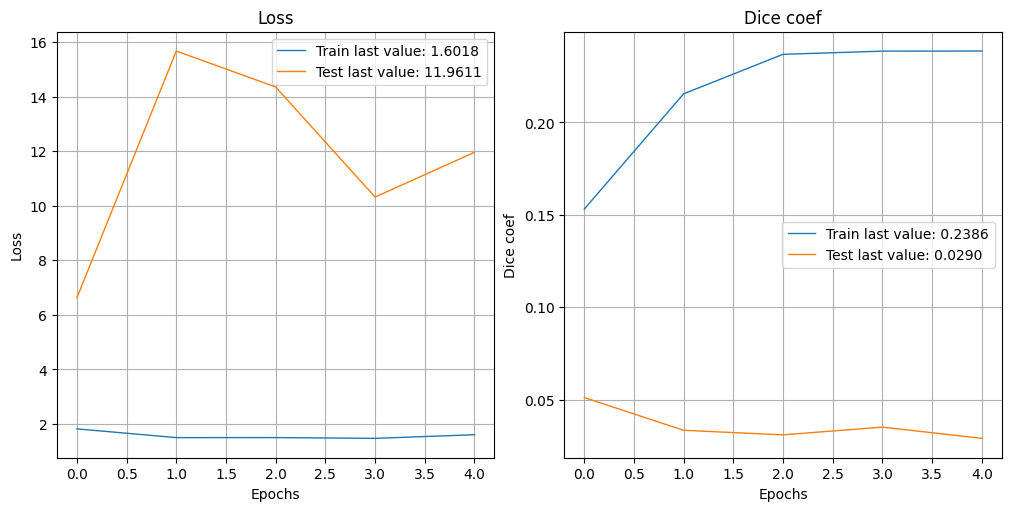

In [ ]:
show_history(history_segnet_aug)
plot_history(history_segnet_aug, path="history_segnet_aug.png")
plt.close()

In [ ]:
# Evaluate the model
loss_segnet_aug, dice_coef_segnet_aug = model_segnet_aug.evaluate(test_generator, steps=30)
print('Loss: {:.2f}'.format(loss_segnet_aug))
print('Dice Coefficient of Segnet augmented: {:.2f}'.format(dice_coef_segnet_aug))

30/30 [==============================] - 17s 549ms/step - loss: 11.9759 - dice_coef: 0.0275
Loss: 11.98
Dice Coefficient of Segnet augmented: 0.03


---

### **Transfer Learning**

In [ ]:
def unet_vgg16(input_shape=(256, 256, 3), num_classes=8):
    # Load pre-trained VGG16 model as encoder
    vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    # Retrieve outputs from layers of interest
    conv1 = vgg16.get_layer('block1_conv2').output
    conv2 = vgg16.get_layer('block2_conv2').output
    conv3 = vgg16.get_layer('block3_conv3').output
    conv4 = vgg16.get_layer('block4_conv3').output
    conv5 = vgg16.get_layer('block5_conv3').output

    # Create the decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)

    output = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=vgg16.input, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[dice_coef])

    return model

In [ ]:
# Create the model
model_unet_vgg16 = unet_vgg16()

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
start_time = time.time()

# Train the model
history_unet_vgg16 = model_unet_vgg16.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    use_multiprocessing=True,
    workers=6,
)

end_time = time.time()
training_time_unet_vgg16 = end_time - start_time
print(f"Training time: {training_time_unet_vgg16} seconds")

Epoch 1/5
125/125 [==============================] - 798s 6s/step - loss: 2.5666 - dice_coef: 0.4222 - val_loss: 0.9259 - val_dice_coef: 0.5556
Epoch 2/5
125/125 [==============================] - 115s 921ms/step - loss: 0.8722 - dice_coef: 0.5756 - val_loss: 0.7993 - val_dice_coef: 0.6089
Epoch 3/5
125/125 [==============================] - 102s 815ms/step - loss: 0.7497 - dice_coef: 0.6346 - val_loss: 0.7738 - val_dice_coef: 0.6282
Epoch 4/5
125/125 [==============================] - 102s 814ms/step - loss: 0.6886 - dice_coef: 0.6675 - val_loss: 0.7880 - val_dice_coef: 0.6455
Epoch 5/5
125/125 [==============================] - 102s 813ms/step - loss: 0.6289 - dice_coef: 0.7011 - val_loss: 0.7718 - val_dice_coef: 0.7002
Training time: 1264.5068883895874 seconds


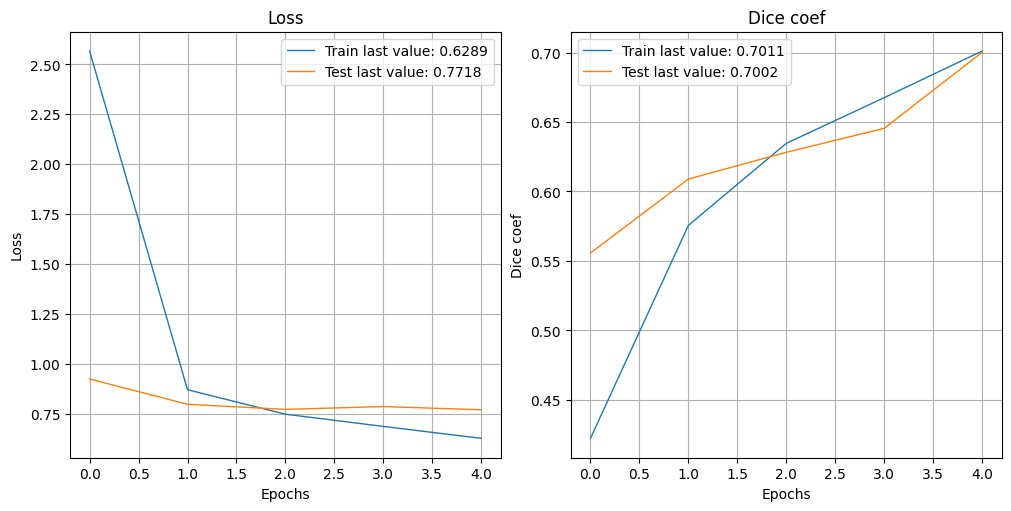

In [ ]:
show_history(history_unet_vgg16)
plot_history(history_unet_vgg16, path="history_unet_vgg16.png")
plt.close()

In [ ]:
# Evaluate the model
loss_unet_vgg16, dice_coef_unet_vgg16 = model_unet_vgg16.evaluate(test_generator, steps=30)
print('Loss: {:.2f}'.format(loss_unet_vgg16))
print('Dice Coefficient of Unet_Vgg16: {:.2f}'.format(dice_coef_unet_vgg16))

30/30 [==============================] - 75s 3s/step - loss: 0.7375 - dice_coef: 0.7076
Loss: 0.74
Dice Coefficient of Unet_Vgg16: 0.71


### **Model with Data Augmentation**

In [ ]:
# Create the model
model_unet_vgg16_aug = unet_vgg16()

In [ ]:
start_time = time.time()

# Train the model
history_unet_vgg16_aug = model_unet_vgg16_aug.fit(
    train_generator_aug,
    steps_per_epoch=len(train_generator_aug),
    epochs=5,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    use_multiprocessing=True,
    workers=6,
)

end_time = time.time()
training_time_unet_vgg16_aug = end_time - start_time
print(f"Training time: {training_time_unet_vgg16_aug} seconds")

Epoch 1/5
125/125 [==============================] - 118s 889ms/step - loss: 21.0571 - dice_coef: 0.1376 - val_loss: 2.0154 - val_dice_coef: 0.1335
Epoch 2/5
125/125 [==============================] - 112s 893ms/step - loss: 1.7709 - dice_coef: 0.1259 - val_loss: 1.9426 - val_dice_coef: 0.1445
Epoch 3/5
125/125 [==============================] - 112s 900ms/step - loss: 1.7491 - dice_coef: 0.1365 - val_loss: 1.8813 - val_dice_coef: 0.1555
Epoch 4/5
125/125 [==============================] - 110s 883ms/step - loss: 1.6798 - dice_coef: 0.1485 - val_loss: 1.8307 - val_dice_coef: 0.1660
Epoch 5/5
125/125 [==============================] - 111s 888ms/step - loss: 1.6184 - dice_coef: 0.1591 - val_loss: 1.7889 - val_dice_coef: 0.1760
Training time: 625.0357978343964 seconds


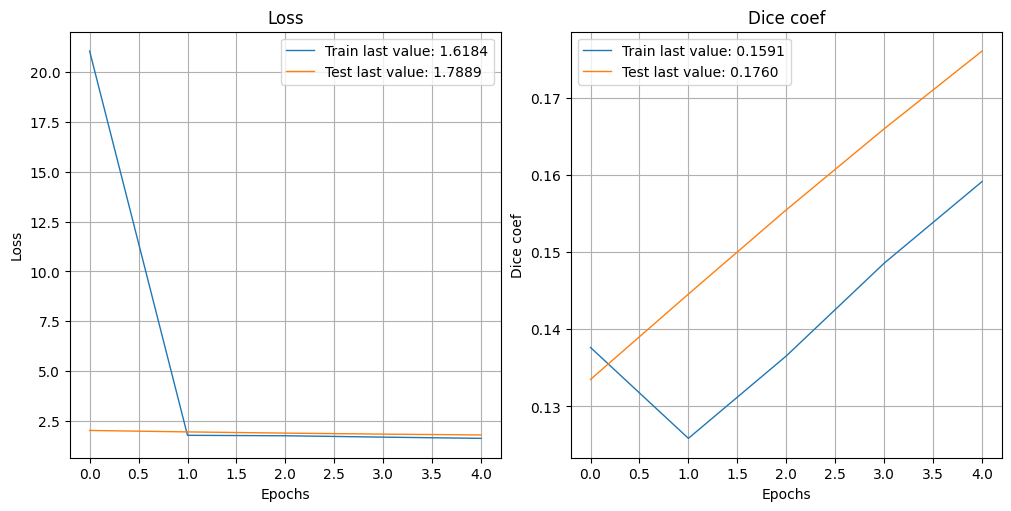

In [ ]:
show_history(history_unet_vgg16_aug)
plot_history(history_unet_vgg16_aug, path="history_unet_vgg16_aug.png")
plt.close()

In [ ]:
# Evaluate the model
loss_unet_vgg16_aug, dice_coef_unet_vgg16_aug = model_unet_vgg16_aug.evaluate(test_generator, steps=30)
print('Loss: {:.2f}'.format(loss_unet_vgg16_aug))
print('Dice Coefficient of Unet_Vgg16: {:.2f}'.format(dice_coef_unet_vgg16_aug))

30/30 [==============================] - 17s 573ms/step - loss: 1.7861 - dice_coef: 0.1762
Loss: 1.79
Dice Coefficient of Unet_Vgg16: 0.18


---

In [ ]:
def segnet_vgg16(input_shape=(256, 256, 3), num_classes=8):
    # Load pre-trained VGG16 model as encoder
    vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    # Retrieve outputs from layers of interest
    conv1 = vgg16.get_layer('block1_conv2').output
    conv2 = vgg16.get_layer('block2_conv2').output
    conv3 = vgg16.get_layer('block3_conv3').output
    conv4 = vgg16.get_layer('block4_conv3').output
    conv5 = vgg16.get_layer('block5_conv3').output

    # Create the decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)

    output = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=vgg16.input, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[dice_coef])

    return model

In [ ]:
# Create the template
model_segnet_vgg16 = segnet_vgg16(input_shape=(256, 256, 3), num_classes=8)

In [ ]:
start_time = time.time()

# Train the model
history_segnet_vgg16 = model_segnet_vgg16.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    use_multiprocessing=True,
    workers=6,
)

end_time = time.time()
training_time_segnet_vgg16 = end_time - start_time
print(f"Training time: {training_time_segnet_vgg16} seconds")

Epoch 1/5
125/125 [==============================] - 108s 810ms/step - loss: 0.8026 - dice_coef: 0.6356 - val_loss: 1.3289 - val_dice_coef: 0.6725
Epoch 2/5
125/125 [==============================] - 102s 813ms/step - loss: 0.5947 - dice_coef: 0.7272 - val_loss: 0.8348 - val_dice_coef: 0.7244
Epoch 3/5
125/125 [==============================] - 101s 812ms/step - loss: 0.5512 - dice_coef: 0.7466 - val_loss: 9.5509 - val_dice_coef: 0.2460
Epoch 4/5
125/125 [==============================] - 102s 814ms/step - loss: 0.5087 - dice_coef: 0.7640 - val_loss: 0.5602 - val_dice_coef: 0.7870
Epoch 5/5
125/125 [==============================] - 114s 917ms/step - loss: 0.4762 - dice_coef: 0.7805 - val_loss: 0.6704 - val_dice_coef: 0.7582
Training time: 567.7297310829163 seconds


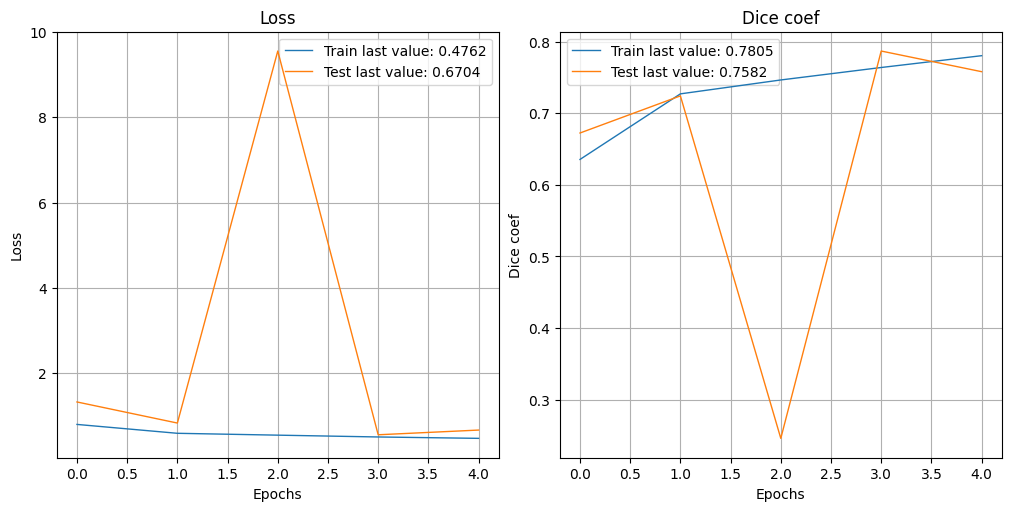

In [ ]:
show_history(history_segnet_vgg16)
plot_history(history_segnet_vgg16, path="history_segnet_vgg16.png")
plt.close()

In [ ]:
# Evaluate the model
loss_segnet_vgg16, dice_coef_segnet_vgg16 = model_segnet_vgg16.evaluate(test_generator, steps=30)
print('Loss: {:.2f}'.format(loss_segnet_vgg16))
print('Dice Coefficient of Segnet_Vgg16: {:.2f}'.format(dice_coef_segnet_vgg16))

30/30 [==============================] - 17s 550ms/step - loss: 0.6274 - dice_coef: 0.7712
Loss: 0.63
Dice Coefficient of Segnet_Vgg16: 0.77


### **Model with Data Augmentation**

In [ ]:
# Create the template
model_segnet_vgg16_aug = segnet_vgg16(input_shape=(256, 256, 3), num_classes=8)

In [ ]:
start_time = time.time()

# Train the model
history_segnet_vgg16_aug = model_segnet_vgg16_aug.fit(
    train_generator_aug,
    steps_per_epoch=len(train_generator_aug),
    epochs=5,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    use_multiprocessing=True,
    workers=6,
)

end_time = time.time()
training_time_segnet_vgg16_aug = end_time - start_time
print(f"Training time: {training_time_segnet_vgg16_aug} seconds")

Epoch 1/5
125/125 [==============================] - 119s 894ms/step - loss: 1.7368 - dice_coef: 0.1506 - val_loss: 2.4501 - val_dice_coef: 0.1251
Epoch 2/5
125/125 [==============================] - 112s 897ms/step - loss: 1.4986 - dice_coef: 0.2227 - val_loss: 1.7678 - val_dice_coef: 0.2086
Epoch 3/5
125/125 [==============================] - 126s 1s/step - loss: 1.4359 - dice_coef: 0.2424 - val_loss: 1.9318 - val_dice_coef: 0.2093
Epoch 4/5
125/125 [==============================] - 111s 892ms/step - loss: 1.5064 - dice_coef: 0.2456 - val_loss: 3.1406 - val_dice_coef: 0.0633
Epoch 5/5
125/125 [==============================] - 112s 895ms/step - loss: 1.4519 - dice_coef: 0.2434 - val_loss: 1.9718 - val_dice_coef: 0.1438
Training time: 671.1691253185272 seconds


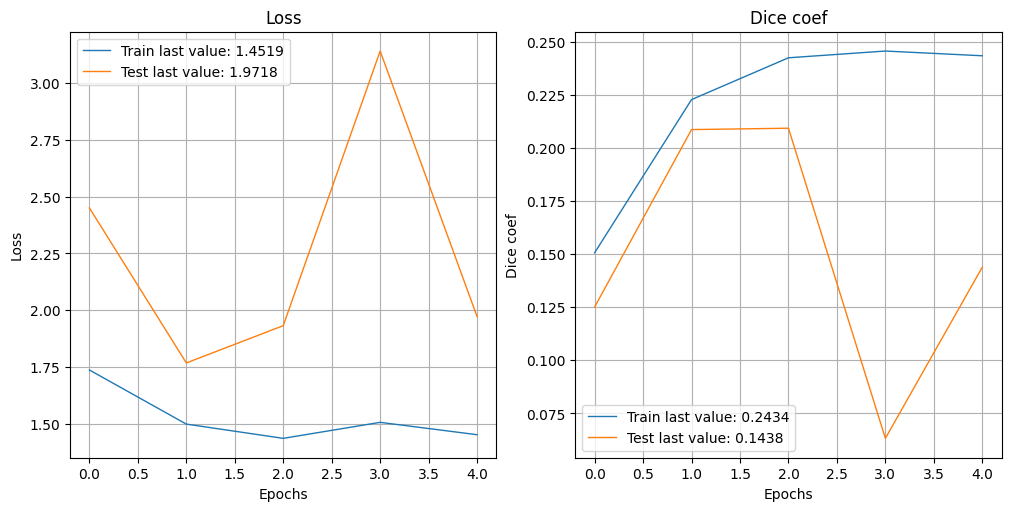

In [ ]:
show_history(history_segnet_vgg16_aug)
plot_history(history_segnet_vgg16_aug, path="history_segnet_vgg16_aug.png")
plt.close()

In [ ]:
# Evaluate the model
loss_segnet_vgg16_aug, dice_coef_segnet_vgg16_aug = model_segnet_vgg16_aug.evaluate(test_generator, steps=30)
print('Loss: {:.2f}'.format(loss_segnet_vgg16_aug))
print('Dice Coefficient of Segnet_Vgg16: {:.2f}'.format(dice_coef_segnet_vgg16_aug))

30/30 [==============================] - 17s 548ms/step - loss: 1.9709 - dice_coef: 0.1439
Loss: 1.97
Dice Coefficient of Segnet_Vgg16: 0.14


---

# **Bilan**

## **Result classic models**

In [ ]:
data_unet_mini = {
    'Model': ['Unet Mini', 'Unet Mini Aug'],
    'Train Time (min)': [training_time_unet_mini/60, training_time_unet_mini_aug/60],
    'Dice Coefficient': [dice_coef_unet_mini, dice_coef_unet_mini_aug],
}
bilan_unet_mini = pd.DataFrame(data_unet_mini)
display(bilan_unet_mini)

,Model,Train Time (min),Dice Coefficient
0,Unet Mini,68.655391,0.598732
1,Unet Mini Aug,50.144244,0.024111


In [ ]:
data_segnet = {
    'Model': ['SegNet', 'SegNet Aug'],
    'Train Time (min)': [training_time_segnet/60, training_time_segnet_aug/60],
    'Dice Coefficient': [dice_coef_segnet, dice_coef_segnet_aug],
}
bilan_segnet = pd.DataFrame(data_segnet)
display(bilan_segnet)

,Model,Train Time (min),Dice Coefficient
0,SegNet,20.004852,0.507754
1,SegNet Aug,10.624194,0.027458


## **Result transfer learning models**

In [ ]:
data_unet_vgg16 = {
    'Model': ['Unet VGG16', 'Unet VGG16 Aug'],
    'Train Time (min)': [training_time_unet_vgg16/60, training_time_unet_vgg16_aug/60],
    'Dice Coefficient': [dice_coef_unet_vgg16, dice_coef_unet_vgg16_aug],
}
bilan_unet_vgg16 = pd.DataFrame(data_unet_vgg16)
display(bilan_unet_vgg16)

,Model,Train Time (min),Dice Coefficient
0,Unet VGG16,21.075115,0.707642
1,Unet VGG16 Aug,10.417263,0.176230


In [ ]:
data_segnet_vgg16 = {
    'Model': ['SegNet VGG16', 'SegNet VGG16 Aug'],
    'Train Time (min)': [training_time_segnet_vgg16/60, training_time_segnet_vgg16_aug/60],
    'Dice Coefficient': [dice_coef_segnet_vgg16, dice_coef_segnet_vgg16_aug],
}
bilan_segnet_vgg16 = pd.DataFrame(data_segnet_vgg16)
display(bilan_segnet_vgg16)

,Model,Train Time (min),Dice Coefficient
0,SegNet VGG16,9.462162,0.771238
1,SegNet VGG16 Aug,11.186152,0.143912
